In [22]:
import time
start_time = time.time()

In [23]:

from copy import deepcopy
from datetime import datetime
from IPython.display import HTML
import json
import pandas as pd
from arcgis.gis import GIS
import arcgis.network as network
import arcgis.geocoding as geocoding
import arcgis
from copy import deepcopy
import datetime as dt
from IPython.display import HTML
import json
import pandas as pd
from arcgis.gis import GIS
import arcgis.network as network
import arcgis.geocoding as geocoding
from arcgis.features import FeatureLayer, FeatureSet, FeatureCollection
import arcgis.features.use_proximity as use_proximity
import datetime
# my_gis = GIS('https://www.arcgis.com', 'arcgis_py', 'Gs#4Dp1o!')

# api_key = "AAPK584c0e1d93c94b7184b16cab622fc22akbl58IK1U9Xlnhgaqa3L0U4RG0U_Fkb21i2nHHRKngcdkmbcUBML_sGizmYFZpPN"
# #     api_key = "YOUR_API_KEY"
# my_gis = arcgis.GIS("https://www.arcgis.com", api_key=api_key)

In [24]:
# api_key = "AAPK584c0e1d93c94b7184b16cab622fc22akbl58IK1U9Xlnhgaqa3L0U4RG0U_Fkb21i2nHHRKngcdkmbcUBML_sGizmYFZpPN"
# #     api_key = "YOUR_API_KEY"
# my_gis = arcgis.GIS("https://www.arcgis.com", api_key=api_key)

api_key = "AAPKb924aa22a2c04a43948522166a50233aV7220htxh7Kf9oyEw8YQhKMjEE5pfZ5caL_2ApPUClsueGMtRw4eqirTDtPK0ofP"
#     api_key = "YOUR_API_KEY"
my_gis = arcgis.GIS("https://www.arcgis.com", api_key=api_key)

In [25]:
""" Used to re-order the stops to the desired order
"""
def re_order_stop_cities(fset, start_city, end_city):
    
    stops_cities_flist = []
    last_city = None

    for ea in fset:
        if ea.attributes['NAME'] == start_city:
            stops_cities_flist.insert(0, ea)
        elif ea.attributes['NAME'] == end_city:
            last_city = ea
        else:
            stops_cities_flist.append(ea)
    stops_cities_flist.append(last_city)
 
    return FeatureSet(stops_cities_flist)

In [26]:
route_service_url = my_gis.properties.helperServices.route.url
route_service_url

'https://route.arcgis.com/arcgis/rest/services/World/Route/NAServer/Route_World'

In [27]:
route_service = network.RouteLayer(route_service_url, gis=my_gis)
route_service

<RouteLayer url:"https://route.arcgis.com/arcgis/rest/services/World/Route/NAServer/Route_World">

<Item title:"USA Major Cities" type:Feature Layer Collection owner:esri_dm>
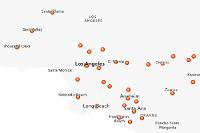

In [28]:
sample_cities = my_gis.content.search('title:"USA Major Cities" type:Feature Service owner:esri*', 
                                      outside_org=True)[0]
sample_cities

In [29]:
start_city = 'Detroit'
start_city_code = 'MI'
end_city = ['Chicago', 'Indianapolis', 'Cleveland', 'Columbus', 'Pittsburgh', 'Buffalo']
end_city_code = ['IL', 'IN', 'OH', 'OH','PA', 'NY']
# end_city = 'Buffalo'
# end_city_code = 'NY'

In [30]:
def origin_destination(sample_cities,start_city, start_city_code, end_city, end_city_code):
    
    stops_cities = [start_city, end_city]
    values = "'" + "', '".join(stops_cities) + "'"
    
    stop_cities_code = [start_city_code, end_city_code]
    values_code = "'" + "', '".join(stop_cities_code) + "'"
    print(values_code)
    
    stops_cities_fl = FeatureLayer(sample_cities.url + "/0")
#     type(stops_cities_fl)
    
    stops_cities_fset = stops_cities_fl.query(where="ST in ({})  AND NAME IN ({})".format(values_code,values), as_df=False)
    # print(stops_cities_fset)
    
    re_ordered_stops_cities_fset = re_order_stop_cities(stops_cities_fset,start_city,end_city)
#     print(re_ordered_stops_cities_fset)
    
    re_ordered_stops_cities_fset.spatial_reference = stops_cities_fset.spatial_reference
    
    re_ordered_stops_cities = list(map(lambda x: x.attributes['NAME'], re_ordered_stops_cities_fset))
    
    stop1_address = start_city
    stop2_address = end_city

    stop1_geocoded = geocoding.geocode(stop1_address)
    stop2_geocoded = geocoding.geocode(stop2_address)

    stops = '{0},{1}; {2},{3}'.format(stop1_geocoded[0]['attributes']['X'],
                                      stop1_geocoded[0]['attributes']['Y'],
                                      stop2_geocoded[0]['attributes']['X'],
                                      stop2_geocoded[0]['attributes']['Y'])

    route_layer_1 = network.RouteLayer(route_service_url, gis=my_gis)
    result1 = route_layer_1.solve(stops=stops, return_directions=False, return_routes=True, 
                               output_lines='esriNAOutputLineNone', return_barriers=False, 
                               return_polygon_barriers=False, return_polyline_barriers=False)

    travel_time = result1['routes']['features'][0]['attributes']['Total_TravelTime']
    print("Total travel time is {0:.2f} min".format(travel_time))

    start_time = int(datetime.datetime.utcnow().timestamp() * 1000)

    route_layer_2 = network.RouteLayer(route_service_url, gis=my_gis)
    result2 = route_layer_2.solve(stops=re_ordered_stops_cities_fset, 
                               directions_language='en-US', return_routes=False,
                               return_stops=False, return_directions=True,
                               directions_length_units='esriNAUKilometers',
                               return_barriers=False, return_polygon_barriers=False,
                               return_polyline_barriers=False, start_time=start_time,
                               start_time_is_utc=True)
    return result2, re_ordered_stops_cities_fset

In [31]:
# result, re_ordered_stops_cities_fset = origin_destination(sample_cities,start_city, start_city_code, end_city[0], end_city_code[0])
# type(result)

results = []
re_ordered_stops_cities_fset_new = []
for i in range(len(end_city)):
    result, re_ordered_stops_cities_fset = origin_destination(sample_cities,start_city, start_city_code, end_city[i], end_city_code[i])
    results.append(deepcopy(result))
    re_ordered_stops_cities_fset_new.append(deepcopy(re_ordered_stops_cities_fset))

'MI', 'IL'
Total travel time is 265.66 min
'MI', 'IN'
Total travel time is 265.77 min
'MI', 'OH'
Total travel time is 159.98 min
'MI', 'OH'
Total travel time is 199.32 min
'MI', 'PA'
Total travel time is 262.74 min
'MI', 'NY'
Total travel time is 272.09 min


In [32]:
results[0]

{'messages': [{'type': 50,
   'description': 'Input field [FID] was not mapped to a field in the network analysis class "Stops".'},
  {'type': 50,
   'description': 'Input field [CLASS] was not mapped to a field in the network analysis class "Stops".'},
  {'type': 50,
   'description': 'Input field [ST] was not mapped to a field in the network analysis class "Stops".'},
  {'type': 50,
   'description': 'Input field [STFIPS] was not mapped to a field in the network analysis class "Stops".'},
  {'type': 50,
   'description': 'Input field [PLACEFIPS] was not mapped to a field in the network analysis class "Stops".'},
  {'type': 50,
   'description': 'Input field [CAPITAL] was not mapped to a field in the network analysis class "Stops".'},
  {'type': 50,
   'description': 'Input field [POP_CLASS] was not mapped to a field in the network analysis class "Stops".'},
  {'type': 50,
   'description': 'Input field [POPULATION] was not mapped to a field in the network analysis class "Stops".'},
 

In [33]:
# print(result['messages'])
# print('\n')
# print(result)
# # print(result['feature'])


In [34]:
asd = {}
abc = asd.update(result)
print(abc)

None


In [35]:
records = []
travel_time, time_counter = 0, 0
distance, distance_counter = 0, 0

for i in result['directions'][0]['features']:
    time_of_day = datetime.datetime.fromtimestamp(i['attributes']['arriveTimeUTC'] / 1000).strftime('%H:%M:%S')
    time_counter = i['attributes']['time']
    distance_counter = i['attributes']['length']
    travel_time += time_counter
    distance += distance_counter
    records.append( (time_of_day, i['attributes']['text'], 
                     round(travel_time, 2), round(distance, 2))  )  

In [36]:
pd.set_option('display.max_colwidth', 100)
df = pd.DataFrame.from_records(records, index=[i for i in range(1, len(records) + 1)], 
                               columns=['Time of day', 'Direction text', 
                                        'Duration (min)', 'Distance (km)'])
HTML(df.to_html(index=False))

Time of day,Direction text,Duration (min),Distance (km)
06:19:10,Start at Detroit,0.00,0.00
06:19:10,Go west toward 8th St,0.09,0.01
06:19:15,"Turn left on 8th St, then make a sharp right on Michigan Ave",1.24,0.59
06:20:24,Turn right after the Firestone on Rosa Parks Blvd,1.90,0.90
06:21:03,Turn left after the Bridge on Fisher Fwy W,1.95,0.93
06:21:07,Keep left to I-75 S (Fisher Fwy S),2.70,1.66
06:21:52,Keep left at the fork to merge onto I-75 S toward Toledo,3.94,2.83
06:23:06,Take exit 47B-C on the right to 47 B-C toward Bridge To Canada / Vernor Highway,4.24,3.13
06:23:24,Keep right at exit 47B to merge onto the highway toward Bridge To Canada,11.11,5.43
06:30:16,Continue forward on HWY-3 S (Ambassador Brg),22.49,11.34


In [37]:
# # stops = '''-3.203062,55.906437; -3.190080,55.935570'''

# route_layer = network.RouteLayer(route_service_url, gis=my_gis)
# result = route_layer.solve(stops=re_ordered_stops_cities_fset, 
#                            directions_language='en-US', return_routes=True,
#                            return_stops=True, return_directions=False,
#                            return_barriers=False, return_polygon_barriers=False,
#                            return_polyline_barriers=False)

In [38]:
# my_map = my_gis.map('USA', zoomlevel= 5)
# my_map.basemap = 'satellite'
# # my_map

In [39]:
# # stops = '''-3.203062,55.906437; -3.190080,55.935570'''

# route_layer = network.RouteLayer(route_service_url, gis=my_gis)
# result = route_layer.solve(stops=re_ordered_stops_cities_fset, 
#                            directions_language='en-US', return_routes=True,
#                            return_stops=True, return_directions=False,
#                            return_barriers=False, return_polygon_barriers=False,
#                            return_polyline_barriers=False)

In [40]:
# my_map.clear_graphics()

# stops = '''-3.203062,55.906437; -3.190080,55.935570'''

from random import randint

my_map = my_gis.map(start_city, zoomlevel= 5)

for i in range(len(re_ordered_stops_cities_fset_new)):

    route_layer = network.RouteLayer(route_service_url, gis=my_gis)
    result = route_layer.solve(stops=re_ordered_stops_cities_fset_new[i], 
                               directions_language='en-US', return_routes=True,
                               return_stops=True, return_directions=False,
                               return_barriers=False, return_polygon_barriers=False,
                               return_polyline_barriers=False)

    stop_count = result['routes']['features'][0]['attributes']['StopCount']
    travel_time = result['routes']['features'][0]['attributes']['Total_TravelTime']
    distance = result['routes']['features'][0]['attributes']['Total_Kilometers']

    data = [('Number of stops', stop_count),
            ('Total travel time', '{0:.2f} min'.format(travel_time)),
            ('Total travel distance', '{0:.2f} km'.format(distance))]

    df = pd.DataFrame.from_records(data)
    styles = [    
        dict(selector="td", props=[("padding", "2px")]),
        dict(selector='.row_heading, .blank', props=[('display', 'none;')]),
        dict(selector='.col_heading, .blank', props=[('display', 'none;')])]

    symbol = {
        "type": "esriSLS",
        "style": "esriSLSSolid",
        "color": [randint(0, 255),randint(0, 255),randint(0, 255),],
        "width": 4
    }

    popup_route = {"title": "Route", 
                   "content": df.style.set_table_styles(styles).render()}
    popup_stop = {"title": "Stop {}", 
                  "content": df.style.set_table_styles(styles).render()}

    my_map.draw(result['routes']['features'][0]['geometry'], popup_route, symbol)

    for stop in result['stops']['features']:
        address = geocoding.reverse_geocode(stop['geometry'])['address']['Match_addr']
        my_map.draw(stop['geometry'], 
                    {"title": "Stop {}".format(stop['attributes']['Sequence']), 
                     "content": address})
    
    my_map.zoom = 5
    my_map.basemap = 'satellite'
    my_map

my_map

MapView(layout=Layout(height='400px', width='100%'))

In [41]:
print(result['routes']['features'][0]['geometry'])
my_map.draw(result['routes']['features'][0]['geometry'], popup_route, symbol)
my_map

{'paths': [[[-83.06555193299994, 42.33194080700008], [-83.06570999999997, 42.331890000000044], [-83.06542999999994, 42.33144000000004], [-83.06640999999996, 42.33144000000004], [-83.06693999999999, 42.33143000000007], [-83.06727999999998, 42.33143000000007], [-83.06786999999997, 42.33142000000004], [-83.06842999999998, 42.33142000000004], [-83.07120999999995, 42.33141000000006], [-83.07142999999996, 42.33141000000006], [-83.07174999999995, 42.33141000000006], [-83.07237999999995, 42.33239000000003], [-83.07252999999997, 42.33247000000006], [-83.07275999999996, 42.33282000000003], [-83.07315999999997, 42.33342000000005], [-83.07340999999997, 42.33388000000008], [-83.07375999999994, 42.33377000000007], [-83.07436999999999, 42.333470000000034], [-83.07508999999999, 42.33316000000008], [-83.07633999999996, 42.33282000000003], [-83.07723999999996, 42.33268000000004], [-83.07735999999994, 42.33268000000004], [-83.07778999999994, 42.33268000000004], [-83.07889999999998, 42.332790000000045], [

MapView(layout=Layout(height='400px', width='100%'))

In [42]:
# End Time
end_time = time.time()
# Total Time spent
print('Total time spent: ', end_time - start_time, 'seconds')

Total time spent:  92.74586534500122 seconds
